In [13]:
#!pip list

%matplotlib inline

import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import pickle
# Some nice output
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display, Markdown

import dbmsbenchmarker
import bexhoma
from bexhoma import evaluators
#import evaluator

In [73]:
cut_at = 1
def plot_measures(metric, smoothing=0):
    display(Markdown(f'# Metric {metric}'))
    list_configurations = list(df_benchmarks['configuration'].unique())    
    for configuration in list_configurations:
        #print("Configuration:", configuration)
        display(Markdown(f'## Configuration {configuration}'))
        list_experiment_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration]['experiment_run'].unique()))
        #print(list_experiment_runs)
        for experiment_run in list_experiment_runs:
            #print("Experiment run", experiment_run)
            display(Markdown(f'### Experiment run {experiment_run}'))
            list_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['client'].unique()))
            #print(list_runs)
            #list_targets = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['target'].unique()))
            #print(list_targets)
            num_runs = len(list_runs)
            # Create a 2-column grid layout
            n_cols = 2
            n_rows = num_runs#6#int(np.ceil(len(dfs) / n_cols))  # Calculate rows needed
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows), sharex=True)
            # Flatten axes for easy iteration (handles cases with n_rows == 1 or n_cols == 1)
            axes = axes.flatten()
            i = 0
            for client in list_runs:
                df_part = df_benchmarks[df_benchmarks['configuration'] == configuration]
                df_part = df_part[df_part['experiment_run'] == (experiment_run)]#['threads']
                df_part = df_part[df_part['client'] == (client)]#num_runs * int(client) -2)]
                #print(df_part.T)
                df_total = evaluation.get_benchmark_logs_timeseries_df_aggregated(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
                #print(df_total)
                threads = df_part['threads'].sum()
                pod_count = df_part['pod_count'].mean()
                target = df_part['target'].sum()
                avg = int(df_total['avg'].mean())
                df_total = df_total.rename(columns={'avg': f'avg={avg}'})
                #print(df_part['threads'])
                title = "{}/{} threads - target = {}".format(threads, int(pod_count), target)
                #plt.title(title)
                ax = axes[i]
                i = i + 1
                #print(df_total)
                df_total = df_total.fillna(0)
                if smoothing > 0:
                    df_total[metric] = df_total[metric].rolling(window=smoothing, min_periods=1).mean()
                #print(df_total)
                df_total[:-cut_at].plot(title=title, ax=ax, ylim=(0,df_total[metric].max()), use_index=True)
                #df_total[:-cut_at].plot(title=title, ylim=(0,df_total[metric].max()), use_index=True)
                #print(df_total[:-cut_at].mean().mean())
                df_total = evaluation.get_benchmark_logs_timeseries_df_single(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
                #print(df_total)
                df_combined = pd.DataFrame()
                j=1
                for df in df_total:
                    #df.plot(ylim=(0,df['current_ops_per_sec'].max()))
                    df_single = pd.DataFrame(df[metric][:-cut_at])
                    df_single.columns=["pod "+str(j)]
                    df_combined = pd.merge(df_combined, df_single, how='outer', left_index=True, right_index=True)
                    j = j + 1
                #print(df_combined)
                avg = df_combined.mean().mean()
                df_combined[f'avg={avg}']=avg
                df_combined = df_combined.fillna(0)
                if smoothing > 0:
                    df_combined = df_combined.rolling(window=smoothing, min_periods=1).mean()
                #plt.title(title)
                ax = axes[i]
                i = i + 1
                df_combined.plot(title=title, ax=ax, ylim=(0,df[metric].max()), legend=False, use_index=True)
                #print(df_total[:-cut_at].mean().mean())
            # Hide any unused subplots
            for j in range(num_runs*2, len(axes)):
                fig.delaxes(axes[j])
            plt.tight_layout()
            plt.show()
            #return

In [74]:
code = "1737973818"
path = "/home/perdelt/benchmarks"
evaluation = evaluators.ycsb(code=code, path=path)

In [75]:
df_benchmarks = evaluation.get_df_benchmarking()
#df = df[df.columns.drop(list(df.filter(regex='FAILED')))]
df_benchmarks = evaluation.benchmarking_set_datatypes(df_benchmarks)
df_benchmarks.T

connection_pod,PostgreSQL-64-8-65536-1-2-1,PostgreSQL-64-8-65536-2-2-1,PostgreSQL-64-8-65536-1-3-1,PostgreSQL-64-8-65536-1-3-2,PostgreSQL-64-8-65536-1-3-3,PostgreSQL-64-8-65536-2-3-1,PostgreSQL-64-8-65536-1-2-2,PostgreSQL-64-8-65536-1-2-3,PostgreSQL-64-8-65536-1-3-4,PostgreSQL-64-8-65536-1-3-5,...,PostgreSQL-64-8-65536-1-3-13,PostgreSQL-64-8-65536-1-3-14,PostgreSQL-64-8-65536-2-3-14,PostgreSQL-64-8-65536-2-1-1,PostgreSQL-64-8-65536-1-3-15,PostgreSQL-64-8-65536-2-2-7,PostgreSQL-64-8-65536-2-2-8,PostgreSQL-64-8-65536-2-3-15,PostgreSQL-64-8-65536-1-3-16,PostgreSQL-64-8-65536-2-3-16
connection,PostgreSQL-64-8-65536-1-2,PostgreSQL-64-8-65536-2-2,PostgreSQL-64-8-65536-1-3,PostgreSQL-64-8-65536-1-3,PostgreSQL-64-8-65536-1-3,PostgreSQL-64-8-65536-2-3,PostgreSQL-64-8-65536-1-2,PostgreSQL-64-8-65536-1-2,PostgreSQL-64-8-65536-1-3,PostgreSQL-64-8-65536-1-3,...,PostgreSQL-64-8-65536-1-3,PostgreSQL-64-8-65536-1-3,PostgreSQL-64-8-65536-2-3,PostgreSQL-64-8-65536-2-1,PostgreSQL-64-8-65536-1-3,PostgreSQL-64-8-65536-2-2,PostgreSQL-64-8-65536-2-2,PostgreSQL-64-8-65536-2-3,PostgreSQL-64-8-65536-1-3,PostgreSQL-64-8-65536-2-3
configuration,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,...,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536,PostgreSQL-64-8-65536
experiment_run,1,2,1,1,1,2,1,1,1,1,...,1,1,2,2,1,2,2,2,1,2
client,2,2,3,3,3,3,2,2,3,3,...,3,3,3,1,3,2,2,3,3,3
pod,wwt6l.dbmsbenchmarker,mvpb7.dbmsbenchmarker,pzqnd.dbmsbenchmarker,6rr6b.dbmsbenchmarker,p44gp.dbmsbenchmarker,hpgpf.dbmsbenchmarker,65c7d.dbmsbenchmarker,bn754.dbmsbenchmarker,npzhh.dbmsbenchmarker,5mt5m.dbmsbenchmarker,...,rcv6n.dbmsbenchmarker,dcwpl.dbmsbenchmarker,4ntlj.dbmsbenchmarker,7stk8.dbmsbenchmarker,btxcp.dbmsbenchmarker,8bb7p.dbmsbenchmarker,cxlrs.dbmsbenchmarker,85krb.dbmsbenchmarker,zp8gr.dbmsbenchmarker,wgnxh.dbmsbenchmarker
pod_count,8,8,16,16,16,16,8,8,16,16,...,16,16,16,1,16,8,8,16,16,16
threads,8,8,4,4,4,4,8,8,4,4,...,4,4,4,64,4,8,8,4,4,4
target,8192,8192,4096,4096,4096,4096,8192,8192,4096,4096,...,4096,4096,4096,65536,4096,8192,8192,4096,4096,4096
sf,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
workload,a,a,a,a,a,a,a,a,a,a,...,a,a,a,a,a,a,a,a,a,a


# Metric current_ops_per_sec

## Configuration PostgreSQL-64-8-65536

### Experiment run 1

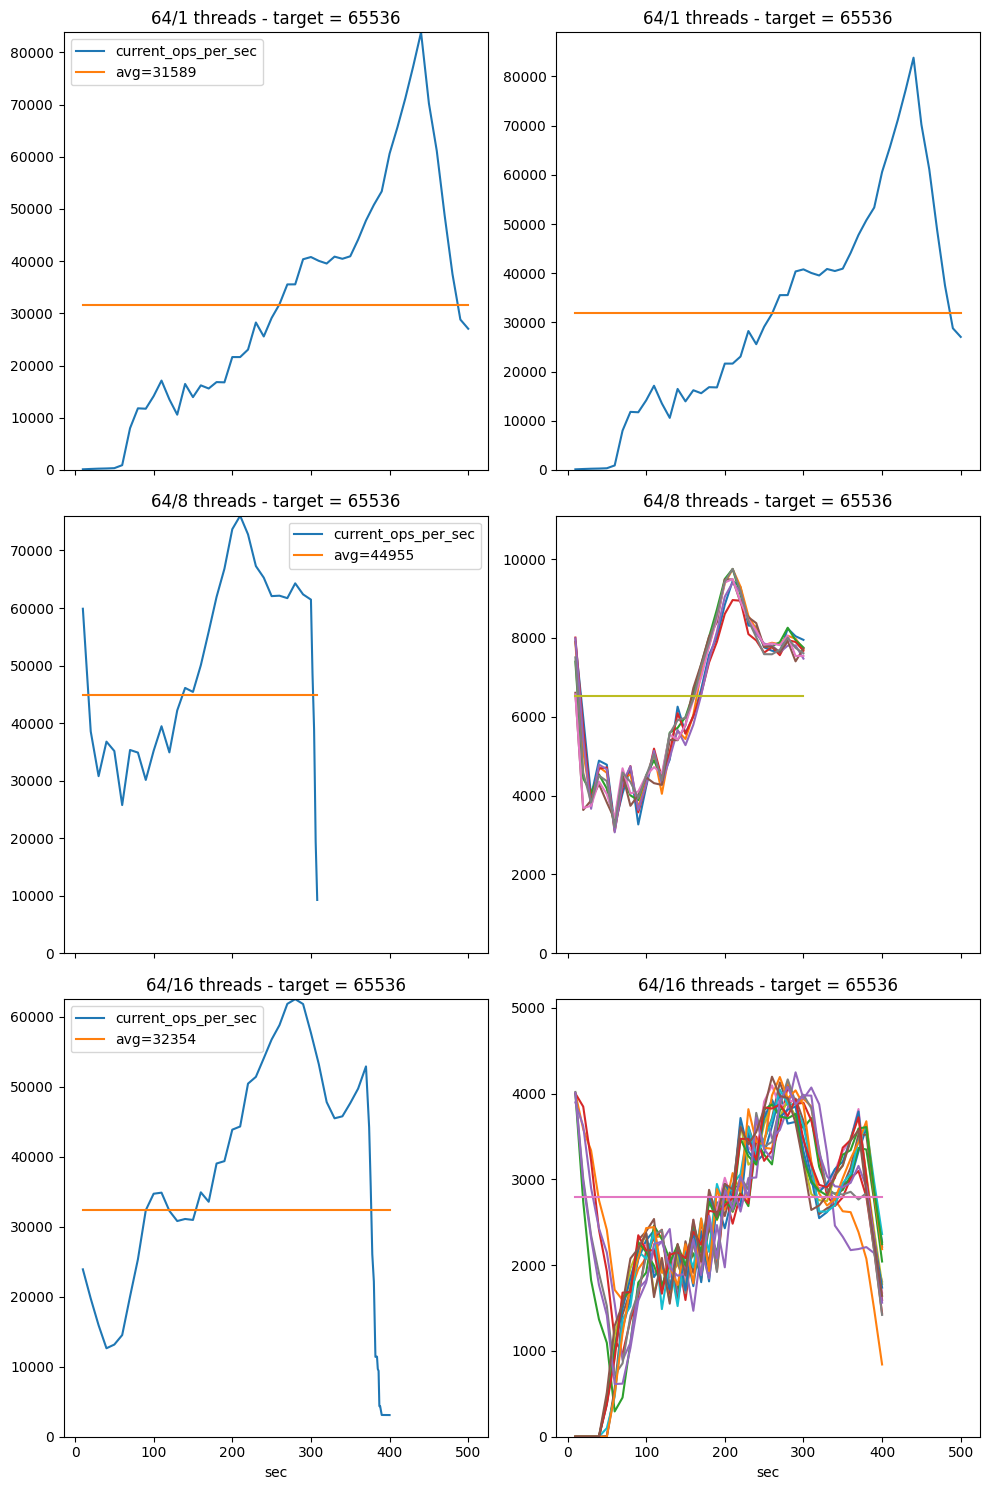

### Experiment run 2

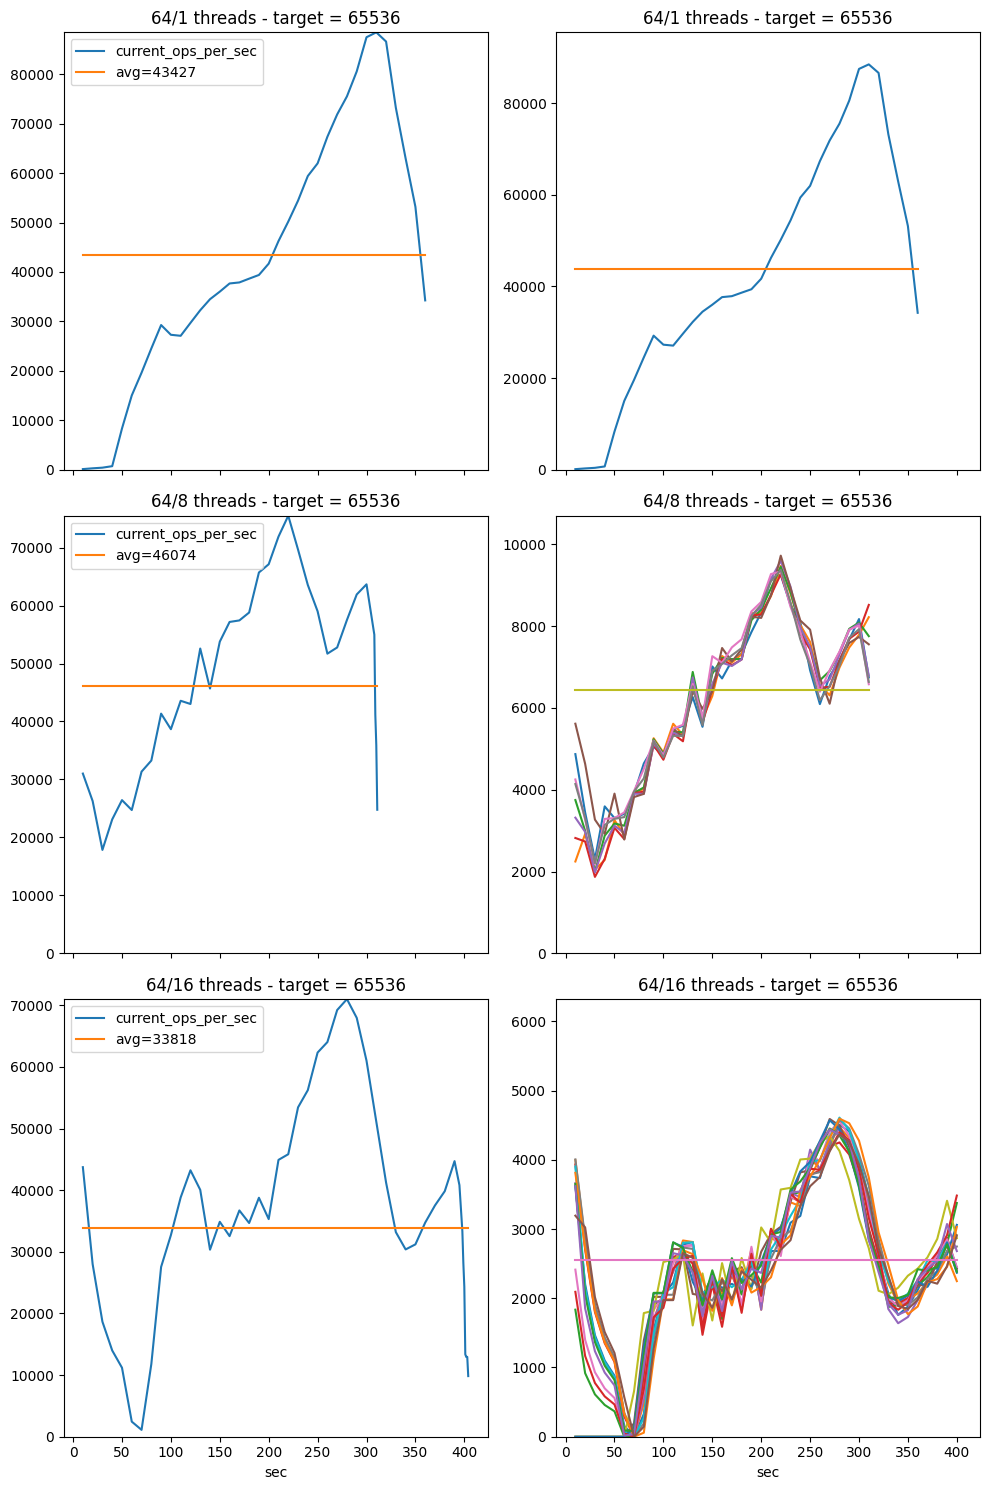

In [76]:
metric = 'current_ops_per_sec'
plot_measures(metric, smoothing=5)

# Metric READ_Avg

## Configuration PostgreSQL-64-8-65536

### Experiment run 1

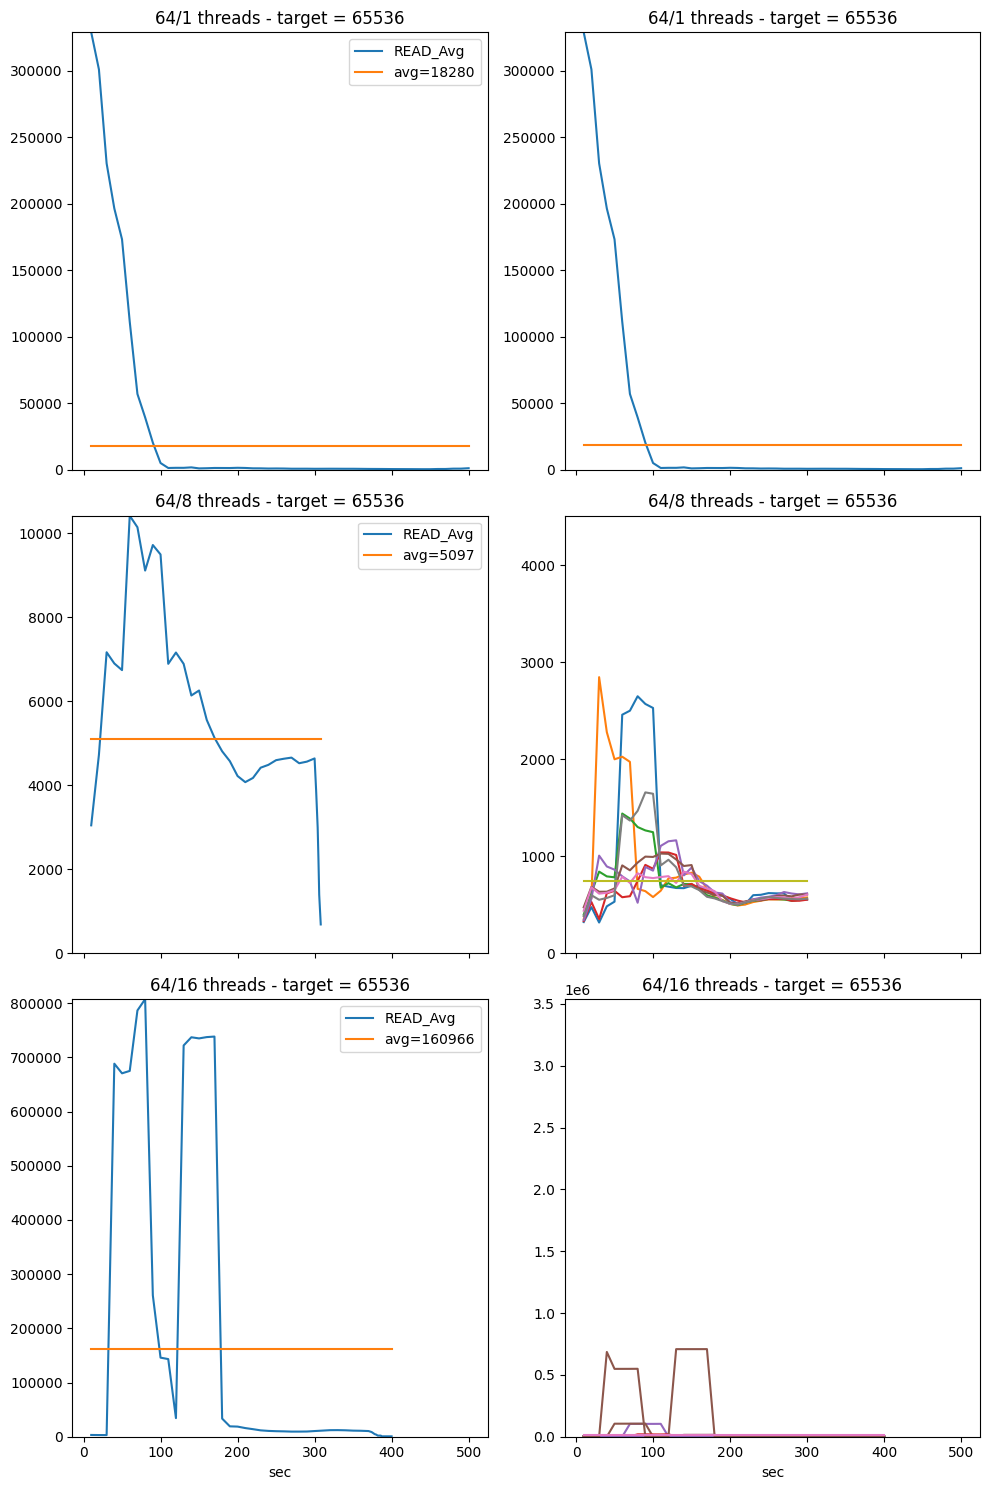

### Experiment run 2

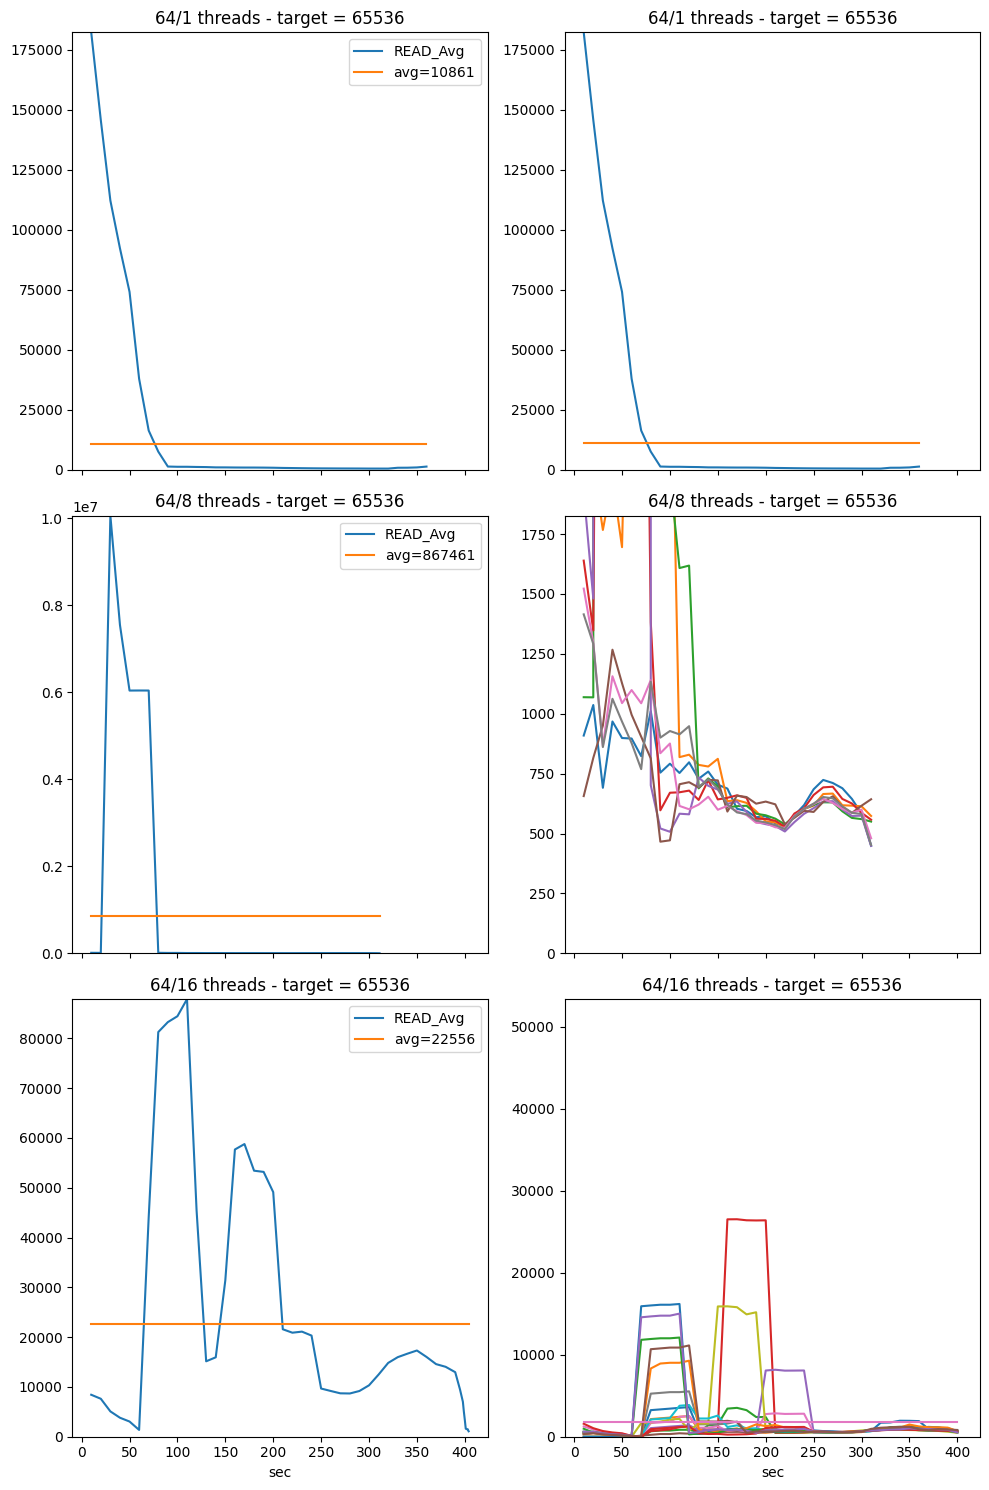

In [82]:
metric = 'READ_Avg'
plot_measures(metric, smoothing=5)

# Metric READ_99.9

## Configuration PostgreSQL-64-8-65536

### Experiment run 1

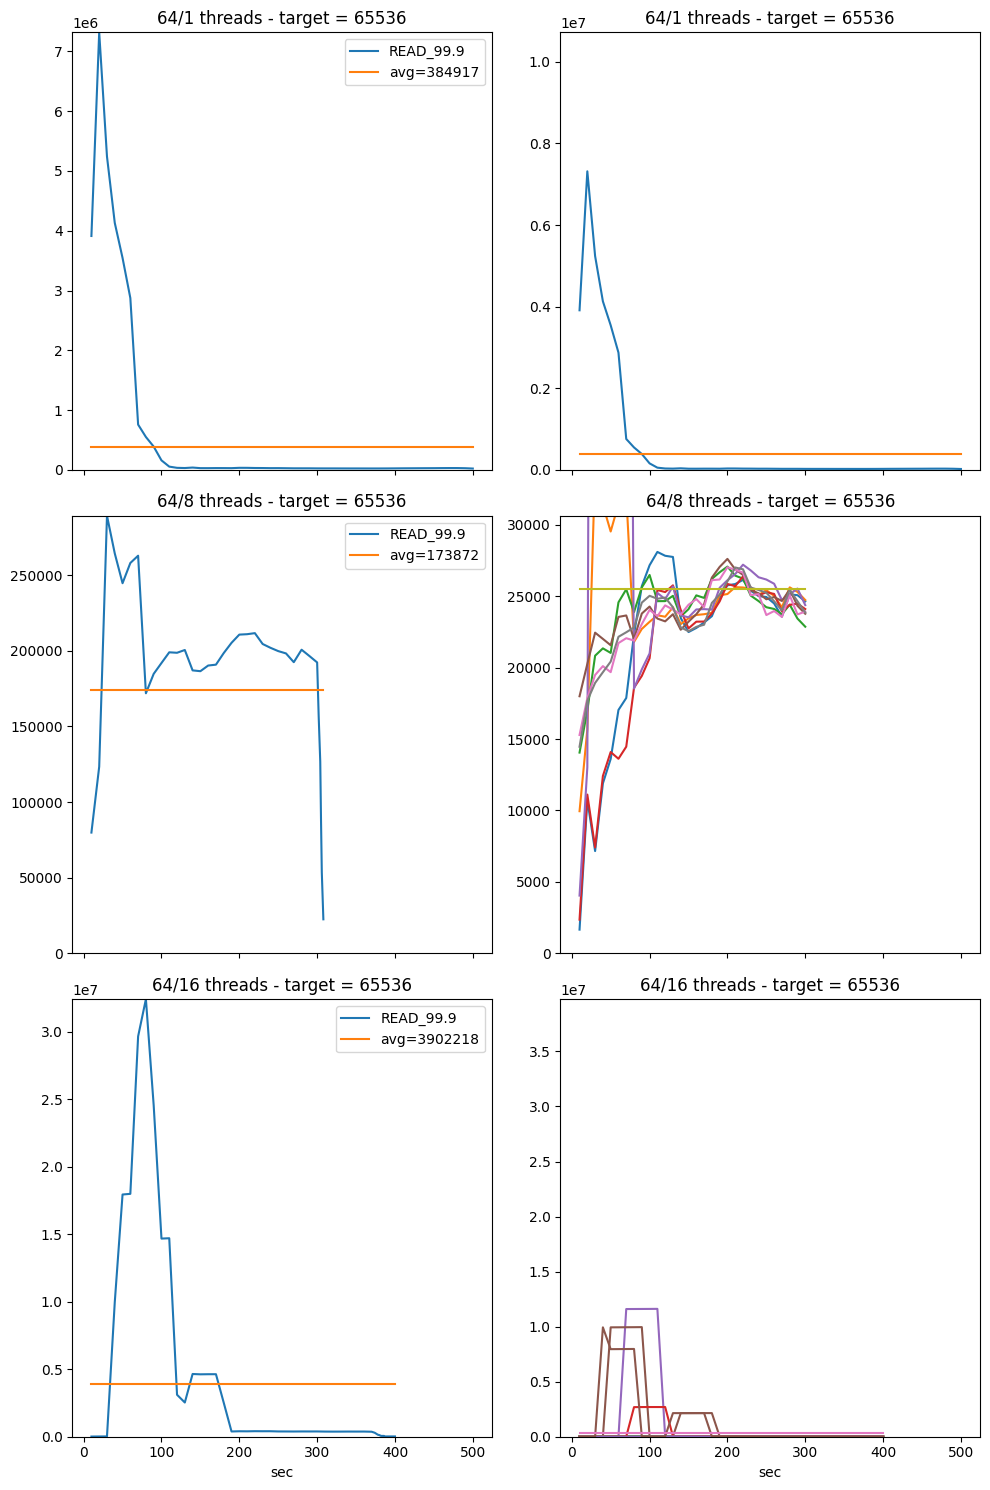

### Experiment run 2

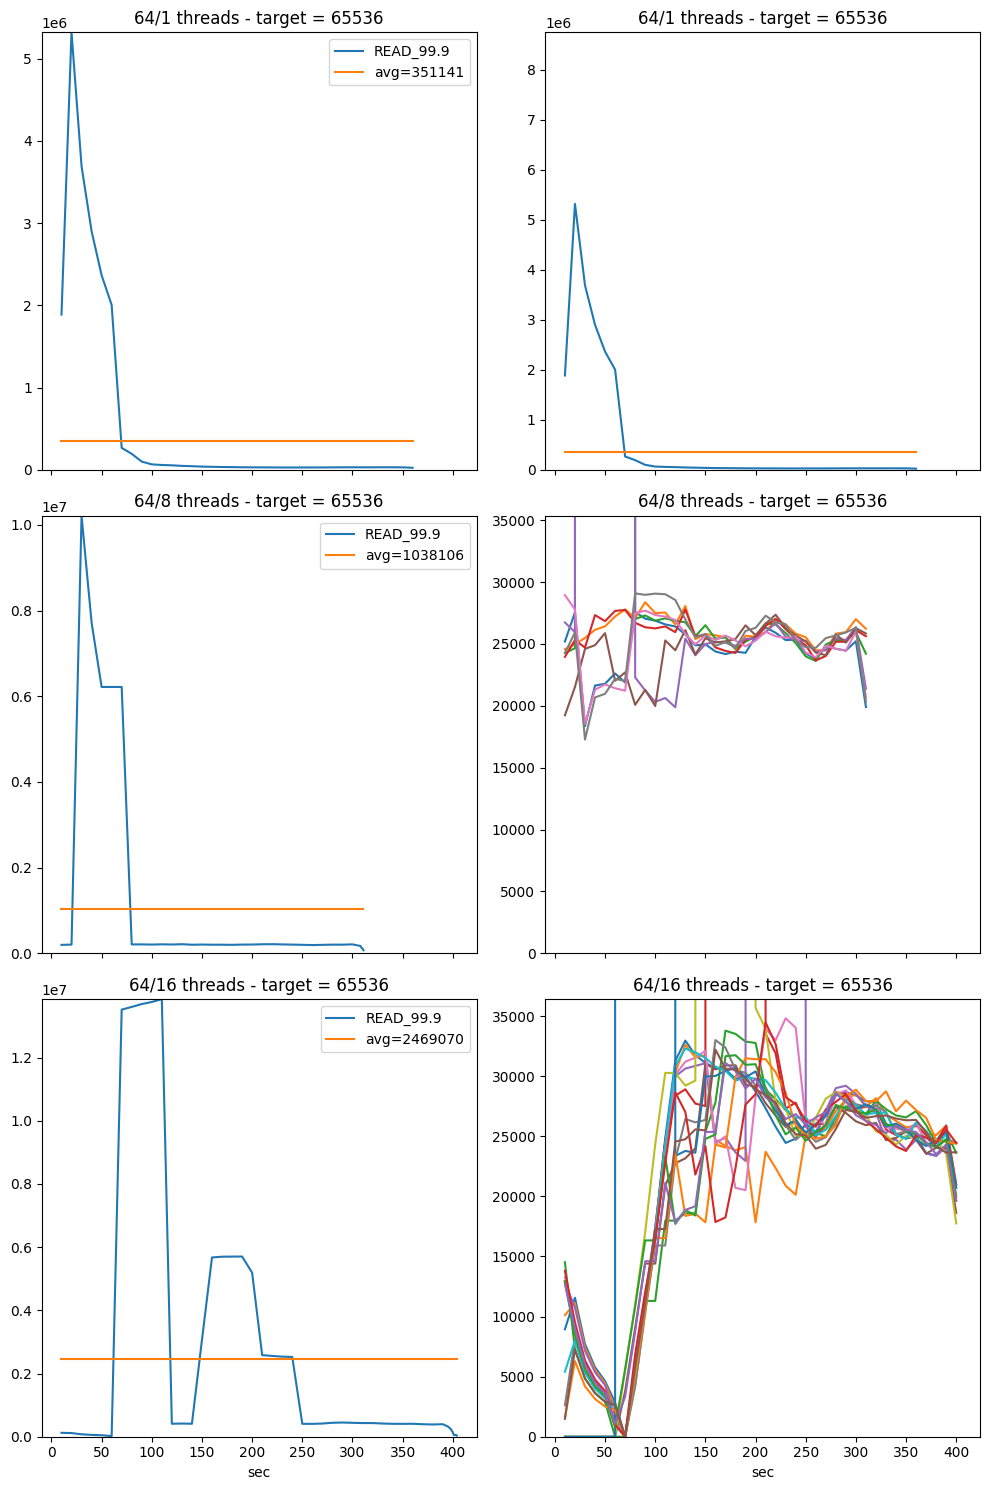

In [81]:
metric = 'READ_99.9'
plot_measures(metric, smoothing=5)

# Metric UPDATE_99.9

## Configuration PostgreSQL-64-8-65536

### Experiment run 1

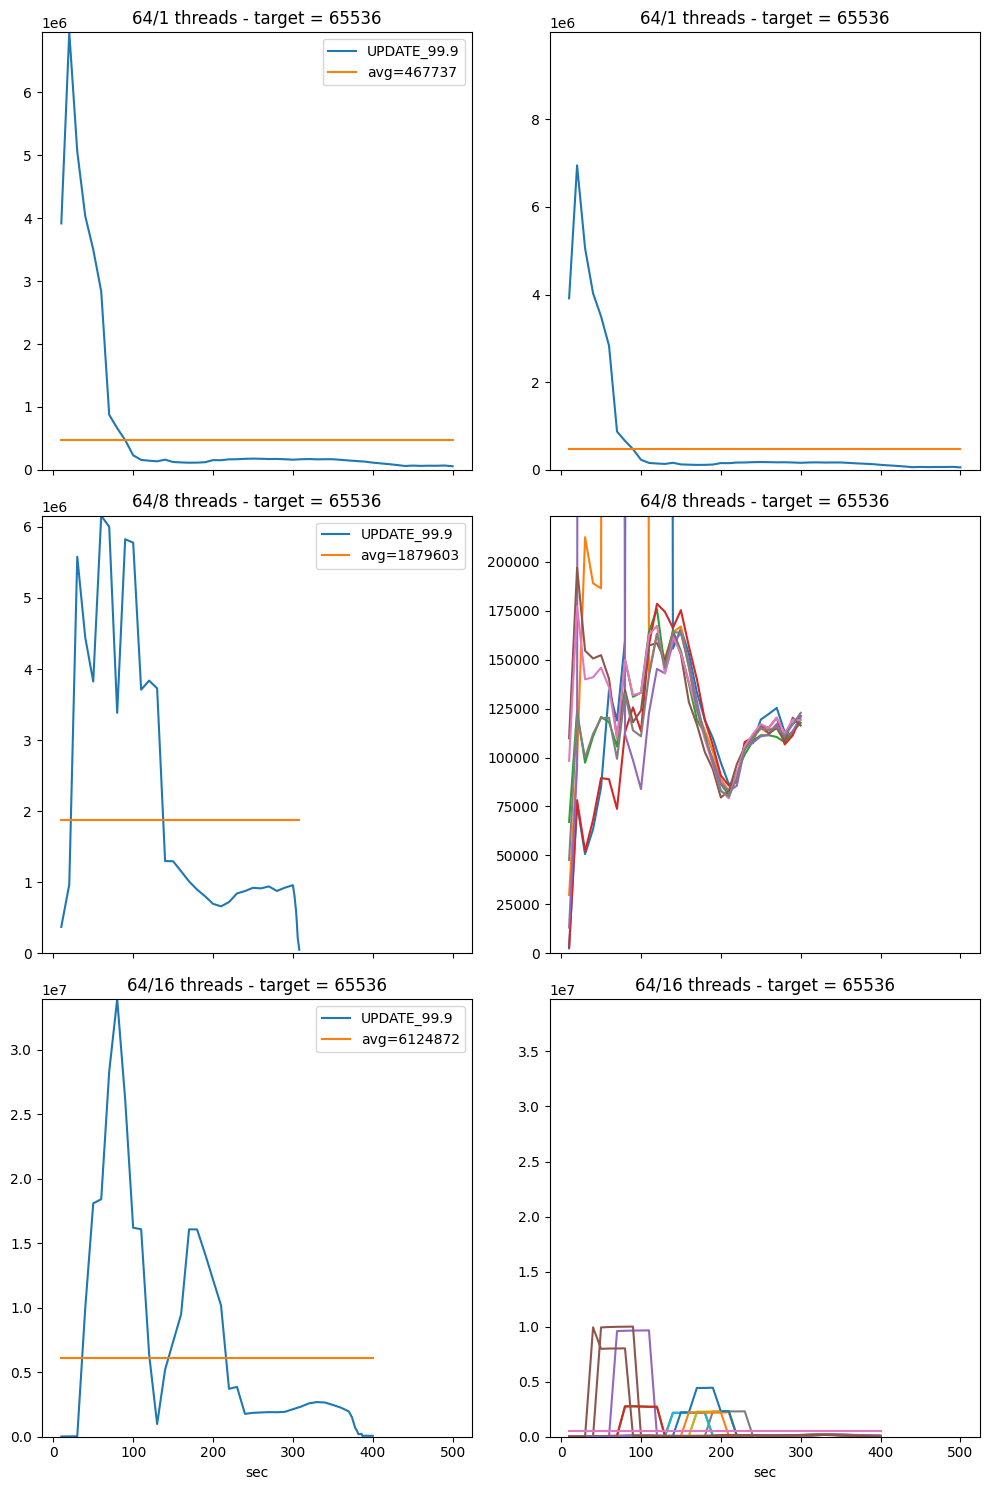

### Experiment run 2

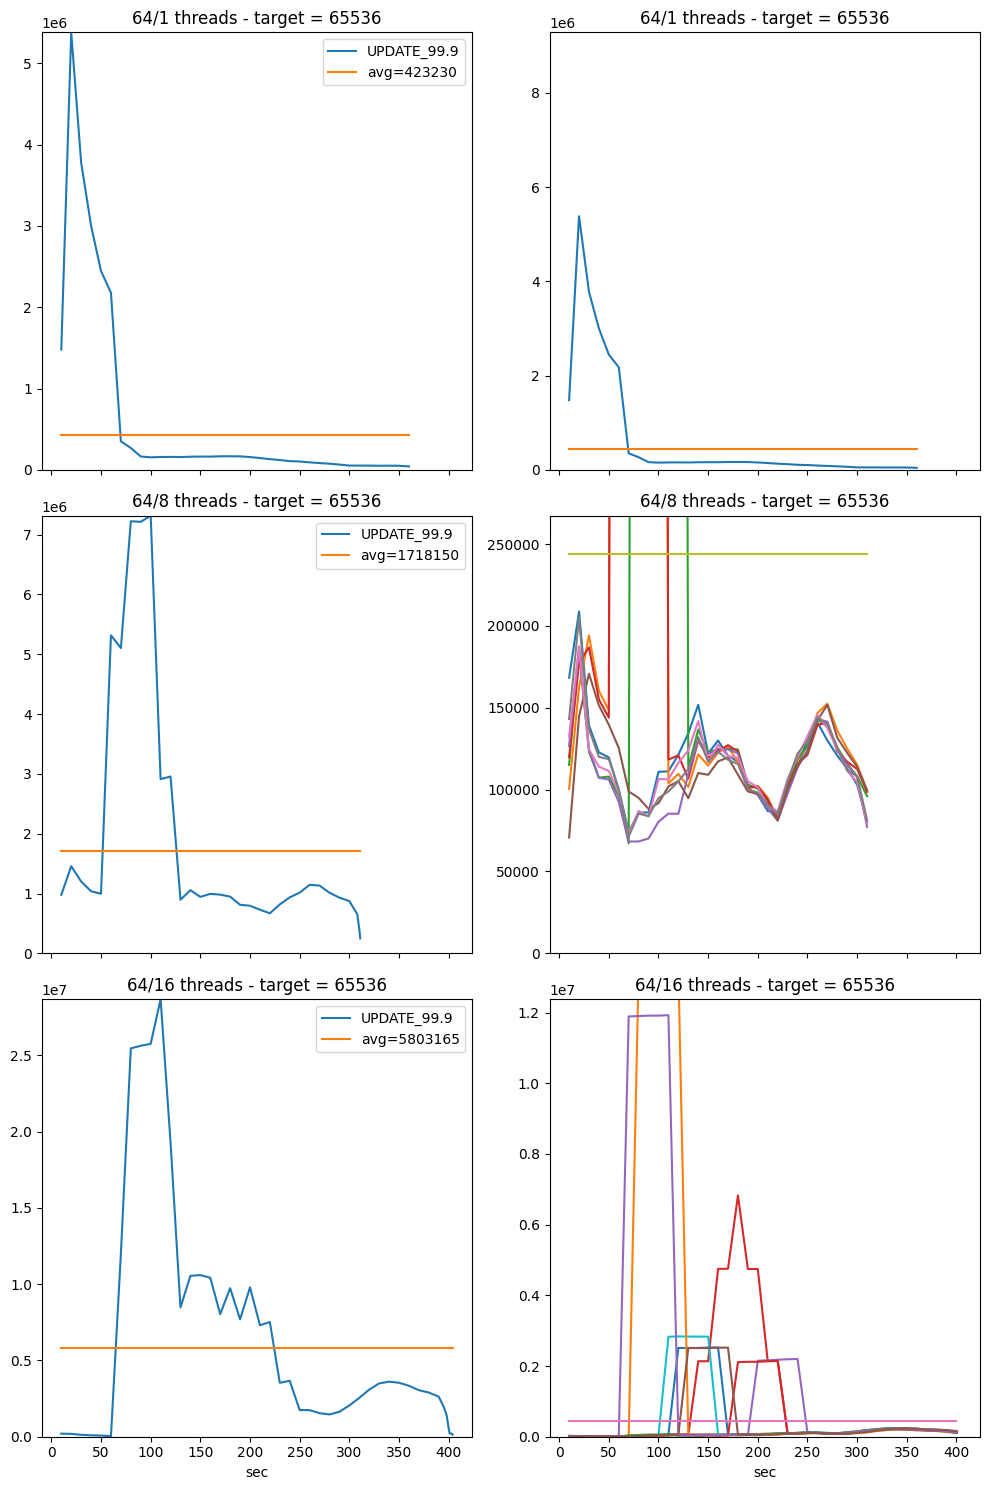

In [80]:
metric = 'UPDATE_99.9'
plot_measures(metric, smoothing=5)